In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt install poppler-utils-y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package poppler-utils-y


In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

In [3]:
!pip install langchain-community

In [4]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [5]:
import nltk
!pip install --upgrade nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [7]:
from google.colab import userdata
openai_api_key=userdata.get('OPEN_AI_API_KEY')

In [8]:
output_path="./images"

In [9]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/AC-Aids-for-Dogs_Canine-Periodontal-Disease.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

<ipython-input-10-683a666e0448>:13: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
<ipython-input-10-683a666e0448>:12: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  summary_chain = LLMChain(
<ipython-input-10-683a666e0448>:20: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  summary = summary_chain.run({'element_type': 'text', 'element': e})


In [13]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [14]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 47.1 MB/s eta 0:00:00


In [15]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

<ipython-input-15-6e6320996726>:42: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


In [16]:
vectorstore.save_local("faiss_index")


In [17]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [19]:
db = FAISS.load_local("faiss_index", embeddings,allow_dangerous_deserialization=True)

In [20]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [21]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4o", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [22]:
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [29]:
result, relevant_images = answer("What is the risk factors of dog's health?")
print(result)

The risk factors for a dog's health, particularly in relation to periodontal disease (PD), include:

1. Age: The older the dog, the higher the likelihood of developing PD.

2. Breed Size: The size of the breed can impact the risk of PD. For instance, shorter-muzzled breeds might be at an increased risk due to overcrowding of the teeth.

3. Specific Breeds: Certain breeds are known to be at an increased risk of PD. For example, Greyhounds have a higher likelihood of developing PD.

4. Presence of Plaque or Tartar: When food and bacteria collect along the gumline, it forms a plaque that can harden into tartar. This tartar irritates the gums, causing inflammation known as gingivitis. If left untreated, the tartar builds up under the gum line, leading to PD.

5. Symptoms: Excessive drooling, loss of appetite, repeated pawing or rubbing of face and mouth, weight loss, aggression, head shyness (moving away) when attempting to look in the mouth, swelling of the face, and difficulty chewing ca

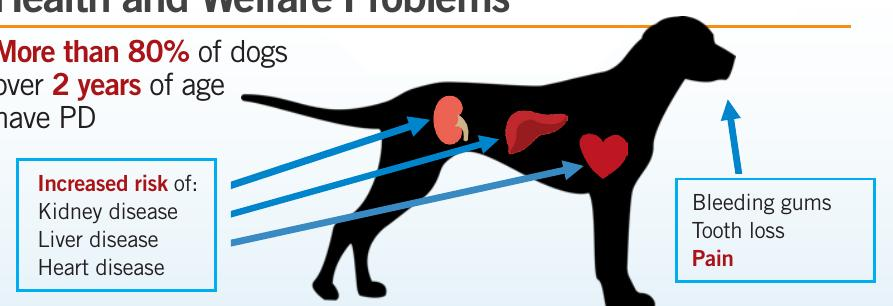

In [30]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

Tartar, also known as dental calculus, is a hard, yellowish-brown deposit that forms on the teeth. It develops when food and bacteria collect along the gumline and the resulting plaque hardens. Tartar irritates the gums, leading to inflammation called gingivitis. If left untreated, the tartar continues to build up under the gum line, potentially resulting in periodontal disease. This can cause dogs to experience pain, infection, abscesses, and tooth loss as the disease becomes more severe. Regular dental care, including brushing and professional cleanings, can help manage and prevent the buildup of tartar.


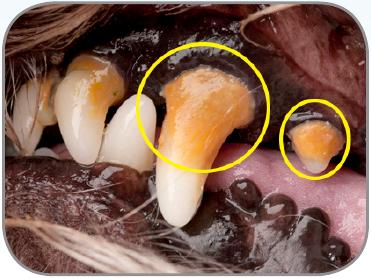

In [31]:
result, relevant_images = answer("What is Tartar?")
print(result)
display.display(display.Image(base64.b64decode(relevant_images[0])))